In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from tqdm import tqdm_notebook

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.utils import (plot_model, ConstrainedGaussian, DatasetMoons, WeirdConstrainedGaussian, 
                           DatasetSIGGRAPH, DatasetMixture, ConstrainedGaussianInner)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

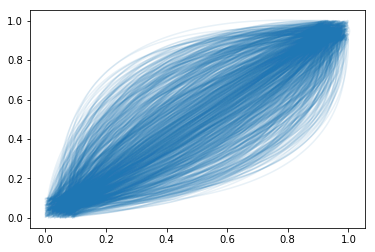

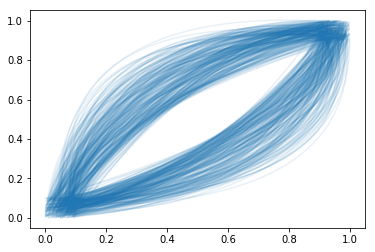

In [2]:
trajectories = []
for i in range(0,1000):
    x = np.loadtxt(f"./rss_code_and_data/avoid/demos/avoid/train/rollout-{i}.txt")
    plt.plot(*x.T, alpha=.1, c='C0')
    
    if ((x[:,0]-.5)**2 + (x[:,1]-.5)**2 < .1**2).sum() == 0:
        trajectories.append(x)
        
plt.show()

for x in trajectories:
    plt.plot(*x.T, alpha=.1, c='C0')
    
plt.show()

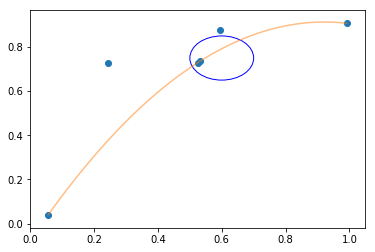

In [3]:
for i in range(10,100):
    i = np.random.choice(range(10,100))
    start = np.loadtxt(f"./rss_code_and_data/avoid/demos/avoid/train/start-state-{i}.txt")
    traj = np.loadtxt(f"./rss_code_and_data/avoid/demos/avoid/train/rollout-{i}.txt")
    plt.scatter(*start.T, alpha=1, c='C0')
    plt.plot(*traj.T, alpha=.5, c='C1')
    y_traj = torch.tensor(traj).float()
    break
    
circle2 = plt.Circle((.6, .75), 0.1, color='b', fill=False)
ax = plt.gca()
ax.add_artist(circle2)

In [4]:
from rss_code_and_data.code.domains import (Box, Segment)

box = Box(torch.zeros(2).float(), torch.ones(2).float())
segment = Segment(torch.zeros(2).float(), torch.ones(2).float())

box.sample()

tensor([0.1005, 0.0520])

In [5]:
from rss_code_and_data.code.constraints import (AvoidPoint)
from rss_code_and_data.code.dmp import (DMP,gen_weights,imitate_path,plot_rollout)
from nflib.nets import MLP
from rss_code_and_data.code import ltldiff as ltd

[[ 0.07167128 -0.38738499 -1.12308986 -2.17987025 -3.57785167 -5.12299022
  -6.01515017 -4.01426486  5.54927744 20.98934017]
 [ 0.27009306 -0.0749985  -0.39812173 -0.70921386 -0.85753137 -0.55875295
   0.55260767  2.35823288  2.41114475 -2.33649037]]


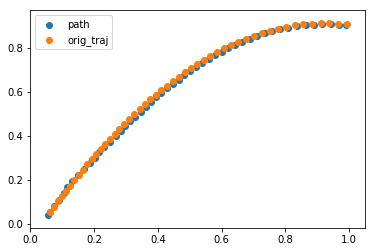

In [6]:
start = traj[0]
goal = traj[-1]

dmp = DMP(10, dt=1/100, d=2)

dmp.T = 100
dmp.start = start
dmp.goal = goal
dmp.y0 = start

path, weights = imitate_path(traj, dmp)

dmp.weights = weights
# dmp.weights = np.zeros_like(weights)

y_track, dy_track, ddy_track = dmp.rollout(tau=1.)
print(weights)

plt.scatter(*y_track.T[:,::2], label='path', alpha=1)
plt.scatter(*traj.T[:,1::2], label='orig_traj', alpha=1)
plt.legend(loc='best')

plt.show()

In [7]:
start = torch.zeros(2)
goal = torch.ones(2)
point = torch.tensor([.6,.85])

dmp.T = 100
dmp.start = start
dmp.goal = goal
weights_orig = torch.tensor(gen_weights(traj, dmp)).float()
print(f"Dim of weights: {weights_orig.size()}")
model = MLP(4, weights_orig.size()[0]*weights_orig.size()[1], nh=100, nlayers=2)

Dim of weights: torch.Size([2, 10])


In [8]:
weights = torch.tensor(gen_weights(traj, dmp)).float()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = []
zs = torch.cat([start, goal])

for i in range(250):
    
    start = y_traj[0]
    goal = y_traj[-1]
    weights = model(torch.cat([start, goal]))
    y_track = dmp.rollout_torch(start, goal, weights=weights.view(*weights_orig.size()), tau=1.)[0][0]
    
    neg_loss = torch.where(
                        (y_track[:,0]-.6)**2 + (y_track[:,1]-.75)**2 < .1**2,
                        (y_track[:,0]-.6)**2 + (y_track[:,1]-.75)**2 - .1**2,
                        torch.zeros_like(y_track[:,0]))
        
    loss = 100*((y_track - y_traj)**2).sum() #- 20*neg_loss.sum()
    model.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

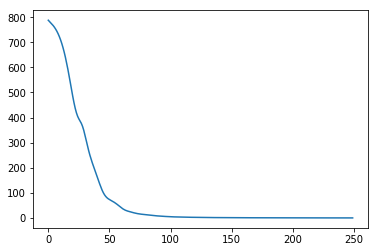

In [9]:
plt.plot(losses)

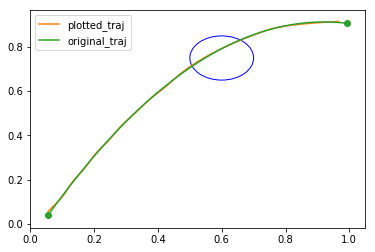

In [10]:
plt.plot(*y_track.detach().numpy().T, c='C1', label='plotted_traj')
# plot_rollout(dmp.rollout_torch(start, goal, weights=weights)[0])
plt.plot(*y_traj.detach().numpy().T, c='C2', label='original_traj')
plt.scatter(*start, c='C2')
plt.scatter(*goal, c='C2')
circle2 = plt.Circle((.6, .75), 0.1, color='b', fill=False)
ax = plt.gca()
ax.add_artist(circle2)
plt.legend(loc='best')

In [67]:
dmp_size = 25
nfs_flow = NSF_CL

def build_model(conditioning=False, num_conditioning=4):
    prior = MultivariateNormal(torch.zeros(dmp_size*2), torch.eye(dmp_size*2))
    flows = [nfs_flow(dim=dmp_size*2, K=5, B=3, hidden_dim=8, 
                      conditioning=conditioning, num_conditioning=num_conditioning) for _ in range(5)]
    convs = [Invertible1x1Conv(dim=dmp_size*2) for _ in flows]
    norms = [ActNorm(dim=dmp_size*2) for _ in flows]
    flows = list(itertools.chain(*zip(norms, convs, flows)))        
#     flows = [AffineHalfFlow(dim=dmp_size*2, parity=i%2, 
#                             conditioning=False, num_conditioning=4) for i in range(15)]
    model = NormalizingFlowModel(prior, flows, conditioning=False)
    return model

In [68]:
print(f"Number of training points: {len(trajectories)}")

Number of training points: 500


In [69]:
from torch.nn.utils import clip_grad_norm_

print("number of params: ", sum(p.numel() for p in model.parameters()))
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
losses = []
batch_size=128

for i in range(2000):
    
    k = np.random.choice(range(0, len(trajectories)),size=batch_size)
    batch = torch.zeros(batch_size, 2, dmp_size)
    
    for n, j in enumerate(k):
        dmp = DMP(dmp_size, dt=1/100, d=2)

        traj = trajectories[j]
        
        start = traj[0]
        goal = traj[-1]

        dmp.T = 100
        dmp.start = start
        dmp.goal = goal
        dmp.y0 = start
        
        path, weights = imitate_path(traj, dmp)
        
        weights = torch.tensor(weights).float()
        batch[n] = weights
    
    zs, prior_logprob, log_det = model(batch.view(batch_size,-1))
    logprob = prior_logprob + log_det
    loss_fwd = -torch.sum(logprob) # NLL
    
    model.zero_grad()
    loss_fwd.backward()
#     clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()
    
    if i % 100 == 1:
        print(i, loss_fwd.item())
        losses.append(loss_fwd.item())

number of params:  19220
1 6562.62548828125
101 -7204.9306640625
201 -9000.615234375
301 -10059.0947265625
401 -10167.32421875
501 -11203.70703125
601 -10842.18359375
701 -11536.841796875
801 -11840.2275390625
901 -11700.095703125
1001 -12275.74609375
1101 -12983.0107421875
1201 -12499.2119140625
1301 -13014.7724609375
1401 -13018.794921875
1501 -13143.484375
1601 -12980.2373046875
1701 -12839.0263671875
1801 -13423.287109375
1901 -14414.0732421875


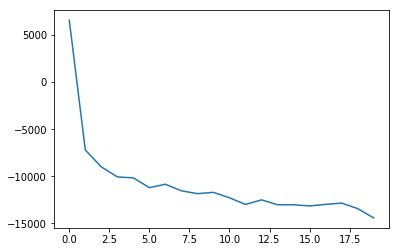

In [70]:
plt.plot(losses)

In [71]:
# import copy
# model_clone = build_model()
# model_clone.flow.load_state_dict(copy.deepcopy(model.flow.state_dict()))
# # model.flow.state_dict()
# model_clone.eval()
# pass

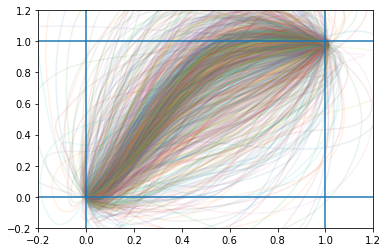

In [72]:
samples = 1000
y_track, dy_track, ddy_track = dmp.rollout_torch(torch.zeros(samples, 2), 
                                                 torch.ones(samples, 2), 
                                                 model.sample(samples)[-1].view(samples,2,dmp_size))
plt.plot(*y_track.detach().numpy().T, alpha=.1)
plt.xlim([-0.2, 1.2])
plt.ylim([-0.2, 1.2])
plt.axvline(x=0, ymin=0, ymax=1)
plt.axvline(x=1, ymin=0, ymax=1)
plt.axhline(y=0, xmin=0, xmax=1)
plt.axhline(y=1, xmin=0, xmax=1)
plt.show()

In [73]:
# batch = torch.zeros(20,2,dmp_size)
    
# for n, j in enumerate(range(1,21)):
#     start = np.loadtxt(f"./rss_code_and_data/avoid/val/start-state-{j}.txt")
#     traj = np.loadtxt(f"./rss_code_and_data/avoid/val/rollout-{j}.txt")
# #     traj = torch.tensor(y_traj).float()
    
#     start = traj[0]
#     goal = traj[-1]

#     dmp.T = 100
#     dmp.start = start
#     dmp.goal = goal
#     dmp.y0 = start

#     path, weights = imitate_path(traj, dmp)
#     weights = torch.tensor(weights).float()
#     batch[n] = weights
    
# zs, prior_logprob, log_det = model_base(batch.view(20,-1))
# prior_logprob

In [74]:
from torch.nn.utils import clip_grad_norm_

# dmp_size = 10
model_base = build_model()
# model.load_state_dict(trained_mdl_state)
print("number of params: ", sum(p.numel() for p in model_base.parameters()))
optimizer = optim.Adam(model_base.parameters(), lr=1e-3, weight_decay=1e-5)
model_base.train()

regularizer = MultivariateNormal(torch.zeros(dmp_size*2), 1.*torch.eye(dmp_size*2))

losses = []
for i in range(2000):
    
    k = np.random.choice(range(0, len(trajectories)),size=batch_size)
    batch = torch.zeros(batch_size, 2, dmp_size)
    
    for n, j in enumerate(k):
        dmp = DMP(dmp_size, dt=1/100, d=2)

        traj = trajectories[j]
        
        start = traj[0]
        goal = traj[-1]

        dmp.T = 100
        dmp.start = start
        dmp.goal = goal
        dmp.y0 = start
        
        path, weights = imitate_path(traj, dmp)
        
        weights = torch.tensor(weights).float()
        batch[n] = weights
    
    zs, prior_logprob, log_det = model_base(batch.view(batch_size,-1))
    logprob = prior_logprob + log_det
    loss_fwd = -torch.sum(logprob) # NLL
    loss = loss_fwd
    
    if i > 0:
        num_samples = np.min([i+2, batch_size])
        z = model_base.prior.sample((num_samples,))

        xs, log_det_back = model_base.backward(z)
        y_track, dy_track, ddy_track = dmp.rollout_torch(torch.zeros(num_samples, 2), 
                                                     torch.ones(num_samples, 2), 
                                                     xs[-1].view(num_samples,2,dmp_size))

#         acceleration_loss = torch.where(dy_track**2 > 2**2,
#                             (dy_track**2 - 4),
#                             torch.zeros_like(dy_track)).sum()
        
        neg_loss = regularizer.log_prob(xs[-1])
        
#         neg_loss -= (ddy_track)**2
        
        neg_loss -= 10e5*torch.where(
                            (y_track[:,:,0]-.5)**2 + (y_track[:,:,1]-.5)**2 < .1**2,
                            (y_track[:,:,0]-.5)**2 + (y_track[:,:,1]-.5)**2 - .1**2,
                            torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
    #         break
        neg_loss -= 10e4*torch.where(
                            (y_track[:,:,0] < 0),
                            (y_track[:,:,0]),
                            torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
        neg_loss -= 10e4*torch.where(
                            (y_track[:,:,1] < 0),
                            (y_track[:,:,1]),
                            torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
        neg_loss -= 10e4*torch.where(
                            (y_track[:,:,0] > 1),
                            (y_track[:,:,0] - 1),
                            torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
        neg_loss -= 10e4*torch.where(
                            (y_track[:,:,1] > 1),
                            (y_track[:,:,1] - 1),
                            torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2

        loss_bkwd = -(torch.sum(neg_loss) + log_det_back.sum()) #+ acceleration_loss
        loss += loss_bkwd        
    
    model_base.zero_grad()
    loss.backward()
    clip_grad_norm_(model_base.parameters(), 1.0)
    optimizer.step()
    
    if i % 100 == 1:
        if i > 200:
            print(i, loss_fwd.item(), loss_bkwd.item())
        else:
            print(i, loss_fwd.item())
        losses.append(loss_fwd.item())

number of params:  60770
1 65345.75
101 20624.71875
201 21130.94921875 18182.18359375
301 16652.01171875 15640.9921875
401 13907.357421875 15072.390625
501 13266.05859375 14762.359375
601 11955.1875 15436.041015625
701 10226.7041015625 14392.068359375
801 9530.466796875 13624.177734375
901 8870.3564453125 13456.6552734375
1001 7624.98681640625 13310.123046875
1101 6916.90966796875 13434.427734375
1201 14347.138671875 21091.03125
1301 6765.5419921875 13187.1923828125
1401 6215.4560546875 12838.7724609375
1501 6881.00390625 12906.3564453125
1601 7023.39990234375 13336.443359375
1701 5932.0009765625 13113.97265625
1801 5406.8212890625 12791.779296875
1901 5300.033203125 13081.78125


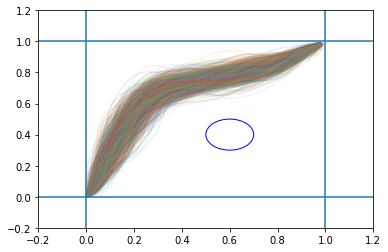

In [75]:
samples = 1000
model_base.eval()
y_track, dy_track, ddy_track = dmp.rollout_torch(torch.zeros(samples, 2), 
                                                 torch.ones(samples, 2), 
                                                 model_base.sample(samples)[-1].view(samples,2,dmp_size))
plt.plot(*y_track.detach().numpy().T, alpha=.1)
plt.xlim([0,1])
plt.ylim([0,1])

circle2 = plt.Circle((.6, .4), 0.1, color='b', fill=False)
ax = plt.gca()
ax.add_artist(circle2)

plt.xlim([-0.2, 1.2])
plt.ylim([-0.2, 1.2])
plt.axvline(x=0, ymin=0, ymax=1)
plt.axvline(x=1, ymin=0, ymax=1)
plt.axhline(y=0, xmin=0, xmax=1)
plt.axhline(y=1, xmin=0, xmax=1)

plt.show()

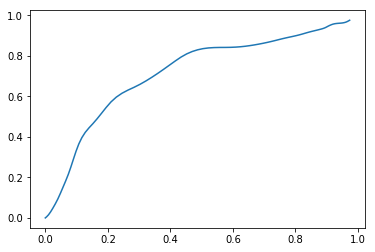

In [76]:
plt.plot(*y_track[np.random.choice(range(1000))].detach().numpy().T, alpha=1)

In [77]:
# model_lim_data = build_model()
# # model.load_state_dict(trained_mdl_state)
# print("number of params: ", sum(p.numel() for p in model_lim_data.parameters()))

# optimizer = optim.Adam(model_lim_data.parameters(), lr=1e-3, weight_decay=1e-5)
# model_lim_data.train()

# regularizer = MultivariateNormal(torch.zeros(dmp_size*2), 1.*torch.eye(dmp_size*2))

# losses = []
# batch_size = 5

# for i in range(1500):
    
#     k = np.random.choice(range(0, batch_size), size=batch_size)
#     batch = torch.zeros(batch_size, 2, dmp_size)
    
#     for n, j in enumerate(k):
#         dmp = DMP(dmp_size, dt=1/100, d=2)

#         traj = trajectories[j]
        
#         start = traj[0]
#         goal = traj[-1]

#         dmp.T = 100
#         dmp.start = start
#         dmp.goal = goal
#         dmp.y0 = start
        
#         path, weights = imitate_path(traj, dmp)
        
#         weights = torch.tensor(weights).float()
#         batch[n] = weights
    
#     zs, prior_logprob, log_det = model_lim_data(batch.view(batch_size,-1))
#     logprob = prior_logprob + log_det
#     loss_fwd = -torch.sum(logprob) # NLL
#     loss = loss_fwd
    
#     if i > 0:
#         num_samples = np.min([i+2, 128])
#         z = model_lim_data.prior.sample((num_samples,))

#         xs, log_det_back = model_lim_data.backward(z)
#         y_track, dy_track, ddy_track = dmp.rollout_torch(torch.zeros(num_samples, 2), 
#                                                      torch.ones(num_samples, 2), 
#                                                      xs[-1].view(num_samples,2, dmp_size))

# #         acceleration_loss = torch.where(dy_track**2 > 2**2,
# #                             (dy_track**2 - 4),
# #                             torch.zeros_like(dy_track)).sum()
        
#         neg_loss = regularizer.log_prob(xs[-1])
        
#         neg_loss -= 10e5*torch.where(
#                             (y_track[:,:,0]-.5)**2 + (y_track[:,:,1]-.5)**2 < .1**2,
#                             (y_track[:,:,0]-.5)**2 + (y_track[:,:,1]-.5)**2 - .1**2,
#                             torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
#     #         break
#         neg_loss -= 10e4*torch.where(
#                             (y_track[:,:,0] < 0),
#                             (y_track[:,:,0]),
#                             torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
#         neg_loss -= 10e4*torch.where(
#                             (y_track[:,:,1] < 0),
#                             (y_track[:,:,1]),
#                             torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
#         neg_loss -= 10e4*torch.where(
#                             (y_track[:,:,0] > 1),
#                             (y_track[:,:,0] - 1),
#                             torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
#         neg_loss -= 10e4*torch.where(
#                             (y_track[:,:,1] > 1),
#                             (y_track[:,:,1] - 1),
#                             torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2

#         loss_bkwd = -(torch.sum(neg_loss) + log_det_back.sum()) #+ acceleration_loss
#         loss += loss_bkwd        
    
#     model_lim_data.zero_grad()
#     loss.backward()
#     clip_grad_norm_(model_lim_data.parameters(), 1.0)
#     optimizer.step()
    
#     if i % 100 == 1:
#         if i > 200:
#             print(i, loss_fwd.item(), loss_bkwd.item())
#         else:
#             print(i, loss_fwd.item())
#         losses.append(loss_fwd.item())

In [78]:
# batch = torch.zeros(20,2,dmp_size)
    
# for n, j in enumerate(range(1,21)):
#     start = np.loadtxt(f"./rss_code_and_data/avoid/val/start-state-{j}.txt")
#     traj = np.loadtxt(f"./rss_code_and_data/avoid/val/rollout-{j}.txt")
# #     traj = torch.tensor(y_traj).float()
    
#     start = traj[0]
#     goal = traj[-1]

#     dmp.T = 100
#     dmp.start = start
#     dmp.goal = goal
#     dmp.y0 = start

#     path, weights = imitate_path(traj, dmp)
#     weights = torch.tensor(weights).float()
#     batch[n] = weights
    
# zs, prior_logprob, log_det = model_lim_data(batch.view(20,-1))
# prior_logprob

In [79]:
# model.eval()

# samples = 1000
# y_track, dy_track, ddy_track = dmp.rollout_torch(torch.zeros(samples, 2), 
#                                                  torch.ones(samples, 2), 
#                                                  model_lim_data.sample(samples)[-1].view(samples,2,dmp_size))
# plt.plot(*y_track.detach().numpy().T, alpha=.1)
# plt.xlim([0,1])
# plt.ylim([0,1])

# circle2 = plt.Circle((.6, .4), 0.1, color='b', fill=False)
# ax = plt.gca()
# ax.add_artist(circle2)

# plt.xlim([-0.2, 1.2])
# plt.ylim([-0.2, 1.2])
# plt.axvline(x=0, ymin=0, ymax=1)
# plt.axvline(x=1, ymin=0, ymax=1)
# plt.axhline(y=0, xmin=0, xmax=1)
# plt.axhline(y=1, xmin=0, xmax=1)

# plt.show()

In [80]:
# plt.plot(*y_track[np.random.choice(range(1000))].detach().numpy().T, alpha=1)

In [81]:
# batch = torch.zeros(20,2,dmp_size)
    
# for n, j in enumerate(range(1,21)):
#     start = np.loadtxt(f"./rss_code_and_data/avoid/val/start-state-{j}.txt")
#     traj = np.loadtxt(f"./rss_code_and_data/avoid/val/rollout-{j}.txt")
# #     traj = torch.tensor(y_traj).float()
    
#     start = traj[0]
#     goal = traj[-1]

#     dmp.T = 100
#     dmp.start = start
#     dmp.goal = goal
#     dmp.y0 = start

#     path, weights = imitate_path(traj, dmp)
#     weights = torch.tensor(weights).float()
#     batch[n] = weights
    
# zs, prior_logprob, log_det = model(batch.view(20,-1))
# prior_logprob

In [82]:
import rss_code_and_data.code.data_gen.curve_funcs as cf

start = np.random.uniform(low=0, high=1, size=2)
end = np.random.uniform(low=0, high=1, size=2)

start_params, trajectory = cf.simpleCurveWithAvoidPoint(
    ([0.0, 1.0], [0.1,0.1]), ([0.9, 0.9], [1.0, 1.0]), ([0.25, 0.25], [0.8, 0.8]))

constraints = [
    {"coords": [.25, .25], 'radius': .1},
    {"coords": [.5, .5], 'radius': .1},
    {"coords": [.8, .25], 'radius': .1},
    {"coords": [.7, .75], 'radius': .1}
]

In [83]:
trajectories = []
params = []

while len(trajectories) < 500:
    start_params, trajectory = cf.simpleCurveWithAvoidPoint(
        start_range=([0.0, 0.0], [0.1,1.0]), 
        goal_range=([0.9, 0.0], [1.0, 1.0]), 
#         start_range=([0, 0.5], [0.01,.51]), 
#         goal_range=([.99, 0.5], [1., 0.51]), 
        attractor_range=([0.25, 0.25], [0.8, 0.8])
    )
    
    valid = True
    for constraint in constraints:
        if np.sum((trajectory[:,0] - constraint['coords'][0])**2+(trajectory[:,1] - constraint['coords'][1])**2
                  < constraint['radius']**2) > 0:
            valid = False
            break
    if valid:
        trajectories.append(trajectory)
        params.append((start_params[0], start_params[-1]))

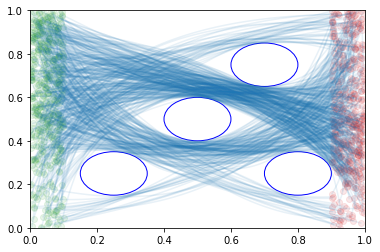

In [84]:
for param, trajectory in zip(params, trajectories):
    plt.plot(*trajectory.T, alpha=.1, c="C0")
    plt.scatter(*param[0], c='C2', alpha=.1)
    plt.scatter(*param[1], c='C3', alpha=.1)

ax = plt.gca()
for constraint in constraints:
    circle = plt.Circle(constraint['coords'], constraint['radius'], color='b', fill=False)
    ax = plt.gca()
    ax.add_artist(circle)

plt.ylim([0,1])
plt.xlim([0,1])
plt.show()

In [85]:
from torch.nn.utils import clip_grad_norm_

def train(model, optimizer, trajectories, params, batch_size=128, n_epochs=1500, backward=False):
    
    losses = []
    batch_size=128
    
    regularizer = MultivariateNormal(torch.zeros(dmp_size*2), 1.*torch.eye(dmp_size*2))
    
    for i in range(n_epochs):
    
        k = np.random.choice(range(0, len(trajectories)),size=batch_size)
        
        batch = torch.zeros(batch_size, 2, dmp_size)
        condition_params = torch.zeros(batch_size, 4)

        for n, j in enumerate(k):
            dmp = DMP(dmp_size, dt=1/100, d=2)

            traj = trajectories[j]

            start = params[j][0]
            goal = params[j][1]

            dmp.T = 100
            dmp.start = start
            dmp.goal = goal
            dmp.y0 = start

            path, weights = imitate_path(traj, dmp)

            weights = torch.tensor(weights).float()
            batch[n] = weights
            condition_params[n] = torch.tensor(
                    [start[0], start[1], goal[0], goal[1]]).float() 

        zs, prior_logprob, log_det = model(batch.view(batch_size,-1), condition_variable=condition_params)
        logprob = prior_logprob + log_det
        loss_fwd = -torch.sum(logprob) # NLL
        loss = loss_fwd
        
        if backward:
            
            num_samples = np.min([i+2, batch_size])
            z = model.prior.sample((num_samples,))
            
            condition_params = start = torch.tensor([
                                    np.random.uniform(0,.1, size=num_samples),
                                    np.random.uniform(0,1., size=num_samples),
                                    np.random.uniform(.9,1., size=num_samples),
                                    np.random.uniform(0,1., size=num_samples)]).float().T
            
            xs, log_det_back = model.backward(z, condition_variable=condition_params)
            y_track, dy_track, ddy_track = dmp.rollout_torch(condition_params[:,:2], 
                                                         condition_params[:,-2:], 
                                                         xs[-1].view(num_samples,2, dmp_size))

    #         acceleration_loss = torch.where(dy_track**2 > 2**2,
    #                             (dy_track**2 - 4),
    #                             torch.zeros_like(dy_track)).sum()

            neg_loss = regularizer.log_prob(xs[-1])
#             neg_loss = 0
            
            for constraint in constraints:
                neg_loss -= 10e5*torch.where(
                    (y_track[:,:,0]-constraint['coords'][0])**2 + 
                        (y_track[:,:,1]-constraint['coords'][1])**2 < constraint['radius']**2,
                    (y_track[:,:,0]-constraint['coords'][0])**2 + 
                        (y_track[:,:,1]-constraint['coords'][1])**2 - constraint['radius']**2,
                    torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
        #         break
            neg_loss -= 10e4*torch.where(
                                (y_track[:,:,0] < 0),
                                (y_track[:,:,0]),
                                torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
            neg_loss -= 10e4*torch.where(
                                (y_track[:,:,1] < 0),
                                (y_track[:,:,1]),
                                torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
            neg_loss -= 10e4*torch.where(
                                (y_track[:,:,0] > 1),
                                (y_track[:,:,0] - 1),
                                torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2
            neg_loss -= 10e4*torch.where(
                                (y_track[:,:,1] > 1),
                                (y_track[:,:,1] - 1),
                                torch.zeros_like(y_track[:,:,0])).sum(dim=1)**2

            loss_bkwd = -(torch.sum(neg_loss) + log_det_back.sum()) #+ acceleration_loss
            loss += loss_bkwd        
        
        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        if i % 100 == 1:
            print(i, loss_fwd.item())
            if backward:
                print('\t\t', loss_bkwd.item())
            losses.append(loss_fwd.item())
            
    return losses

In [86]:
model_complex_no_back = build_model(conditioning=True, num_conditioning=4)
optimizer = optim.Adam(model_complex_no_back.parameters(), lr=1e-3, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model_complex_no_back.parameters()))

losses = train(model_complex_no_back, optimizer, trajectories, params, n_epochs=2500)

number of params:  61090
1 7225.6171875
101 -6391.435546875
201 -6606.103515625
301 -8477.2109375
401 -8696.3876953125
501 -9960.9609375
601 -10312.6171875
701 -11014.7353515625
801 -9420.494140625
901 -11272.7626953125
1001 -10850.3544921875
1101 -11265.9423828125
1201 -12346.837890625
1301 -12335.6015625
1401 -10430.55078125
1501 -12064.46875
1601 -11739.6826171875
1701 -11587.208984375
1801 -12440.5546875
1901 -11942.201171875
2001 -13118.1025390625
2101 -12926.7392578125
2201 -12226.9423828125
2301 -12800.60546875
2401 -13012.0419921875


In [87]:
y_tracks = []
for i in tqdm_notebook(range(100)):
    
#     start = torch.tensor([np.random.uniform(0,.1), np.random.uniform(0,1)]).float()
#     end = torch.tensor([np.random.uniform(.9,1.), np.random.uniform(0,1)]).float()
    start = torch.tensor([0,.5]).float().view(1,-1)
    end = torch.tensor([1,.5]).float().view(1,-1)
    
    for j in range(10):

        sample = model_complex_no_back.sample(1, condition_variable=torch.tensor(
                [start[0,0],start[0,1],end[0,0],end[0,1]]).view(1,-1).float())[-1].view(1,2,dmp_size)
        
        y_track, dy_track, ddy_track = dmp.rollout_torch(
                                                 start, 
                                                 end, 
                                                 sample)
        
        y_tracks.append(y_track.detach().numpy().T)

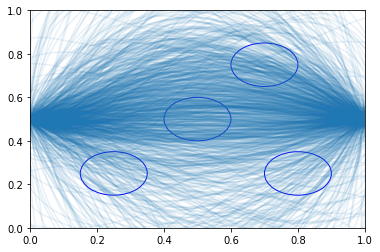

In [88]:
for track in y_tracks:
    plt.plot(*track[:,:,0], alpha=.1, c='C0')
    
ax = plt.gca()
for constraint in constraints:
    circle = plt.Circle(constraint['coords'], constraint['radius'], color='b', fill=False)
    ax = plt.gca()
    ax.add_artist(circle)
plt.ylim([0,1])
plt.xlim([0,1])

plt.show()

In [89]:
model_complex = build_model(conditioning=True, num_conditioning=4)
optimizer = optim.Adam(model_complex.parameters(), lr=1e-3, weight_decay=1e-5)
losses = train(model_complex, optimizer, trajectories, params, n_epochs=2500, backward=True)

1 188826.25
		 181777.140625
101 451638.75
		 430749.90625
201 166231.359375
		 142981.5
301 191712.234375
		 178160.34375
401 119911.796875
		 111360.0234375
501 138905.25
		 132797.1875
601 106842.7890625
		 101192.296875
701 88323.359375
		 82594.1015625
801 78857.046875
		 73532.5
901 62768.97265625
		 58549.90625
1001 45109.76953125
		 43012.03125
1101 34157.9609375
		 31388.337890625
1201 24870.591796875
		 22109.96484375
1301 32988.70703125
		 32263.09765625
1401 20471.529296875
		 20734.95703125
1501 19649.23046875
		 20448.1953125
1601 16056.90234375
		 18070.18359375
1701 18170.115234375
		 19333.08203125
1801 44984.96875
		 47448.21875
1901 14606.4599609375
		 17852.779296875
2001 13628.6875
		 17078.3125
2101 13539.0478515625
		 17138.21484375
2201 16578.10546875
		 19490.646484375
2301 13585.4921875
		 17453.421875
2401 12557.17578125
		 16999.4921875


In [90]:
y_tracks = []
params = []
for i in tqdm_notebook(range(100)):
    
    start = torch.tensor([np.random.uniform(0,.1), np.random.uniform(0,1)]).float().view(1,-1)
    end = torch.tensor([np.random.uniform(.9,1.), np.random.uniform(0,1)]).float().view(1,-1)
#     start = torch.tensor([0,.5]).float().view(1,-1)
#     end = torch.tensor([1,.5]).float().view(1,-1)
    
    for j in range(10):

        sample = model_complex.sample(1, condition_variable=torch.tensor(
                [start[0,0],start[0,1],end[0,0],end[0,1]]).view(1,-1).float())[-1].view(1,2,dmp_size)
        
        y_track, dy_track, ddy_track = dmp.rollout_torch(
                                                 start, 
                                                 end, 
                                                 sample)
        
        y_tracks.append(y_track.detach().numpy().T)
        params.append([start.detach().numpy(), end.detach().numpy()])

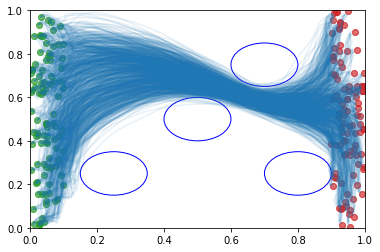

In [91]:
for param, track in zip(params, y_tracks):
    plt.plot(*track[:,:,0], alpha=.1, c='C0')
    plt.scatter(*param[0][0], c='C2', alpha=.1)
    plt.scatter(*param[1][0], c='C3', alpha=.1)
    
ax = plt.gca()
for constraint in constraints:
    circle = plt.Circle(constraint['coords'], constraint['radius'], color='b', fill=False)
    ax = plt.gca()
    ax.add_artist(circle)
plt.ylim([0,1])
plt.xlim([0,1])

plt.show()